In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from pycm import ConfusionMatrix
from sklearn.datasets import fetch_openml
lymph = fetch_openml(name='lymph', version=1)
X = lymph.data
y = lymph.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
from sklearn import svm
classifier_1 = svm.SVC(kernel='linear', C=0.01)

In [6]:
y_pred_1 = classifier_1.fit(X_train, y_train).predict(X_test)

In [7]:
cm1=ConfusionMatrix(y_test,y_pred_1)
cm1.print_matrix()

Predict            fibrosis           malign_lymph       metastases         
Actual
fibrosis           0                  1                  1                  

malign_lymph       0                  11                 8                  

metastases         0                  0                  16                 




In [13]:
cm1.stat(overall_param=['ACC Macro'],class_param=["AUC","TPR", 'DOR', 'FN', 'FP', 'TP','TN', 'MCC', 'PLR', 'TPR', 'TNR', 'PPV', 'NLR'])

Overall Statistics : 

ACC Macro                                                         0.81982

Class Statistics :

Classes                                                           fibrosis         malign_lymph     metastases       
AUC(Area under the ROC curve)                                     0.5              0.7617           0.78571          
DOR(Diagnostic odds ratio)                                        None             23.375           None             
FN(False negative/miss/type 2 error)                              2                8                0                
FP(False positive/type 1 error/false alarm)                       0                1                9                
MCC(Matthews correlation coefficient)                             None             0.55883          0.60474          
NLR(Negative likelihood ratio)                                    1.0              0.44582          0.0              
PLR(Positive likelihood ratio)                          

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm1,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function modified to plots the ConfusionMatrix object.
    Normalization can be applied by setting `normalize=True`.
    
    
    Code Reference : 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    """

    plt_cm1 = []
    for i in cm1.classes :
        row=[]
        for j in cm1.classes:
            row.append(cm1.table[i][j])
        plt_cm1.append(row)
    plt_cm1 = np.array(plt_cm1)
    if normalize:
        plt_cm1 = plt_cm1.astype('float') / plt_cm1.sum(axis=1)[:, np.newaxis]     
    plt.imshow(plt_cm1, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm1.classes))
    plt.xticks(tick_marks, cm1.classes, rotation=45)
    plt.yticks(tick_marks, cm1.classes)

    fmt = '.2f' if normalize else 'd'
    thresh = plt_cm1.max() / 2.
    for i, j in itertools.product(range(plt_cm1.shape[0]), range(plt_cm1.shape[1])):
        plt.text(j, i, format(plt_cm1[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if plt_cm1[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predict')

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

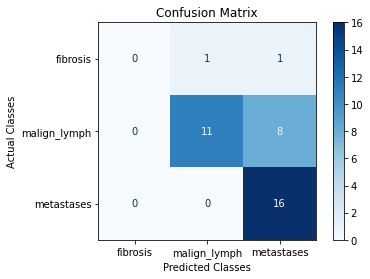

In [35]:
cm1.plot(cmap=plt.cm.Blues,number_label=True,one_vs_all=True)

### Confidence Interval 

We need to estimate the “margin of error” or to use the proper term, confidence interval, on our observation. A confidence interval tells us that at a given level of certainty, if our scientific model is correct, the true value in the population will likely be in the range identified; the larger the confidence interval the less certain the observation will be. There are several different approaches to calculating confidence intervals

In [36]:
import pycm

def plot_ci(cm,param,alpha=0.05,method="normal-approx"):
    """
    Plot two-sided confidence interval.
    
    :param cm: ConfusionMatrix
    :type cm : pycm.ConfusionMatrix object
    :param param: input parameter
    :type param: str
    :param alpha: type I error
    :type alpha: float
    :param method: binomial confidence intervals method
    :type method: str
    :return: None
    """
    conf_str = str(round(100*(1-alpha)))
    print(conf_str+"%CI :")
    if param in cm.class_stat.keys():
        mean = []
        error = [[],[]]
        data = cm.CI(param,alpha=alpha,binom_method=method)
        class_names_str = list(map(str,(cm.classes)))
        for class_index, class_name in enumerate(cm.classes):
            print(str(class_name)+" : "+str(data[class_name][1]))
            mean.append(cm.class_stat[param][class_name])
            error[0].append(cm.class_stat[param][class_name]-data[class_name][1][0])
            error[1].append(data[class_name][1][1]-cm.class_stat[param][class_name])
        fig = plt.figure()
        plt.errorbar(mean,class_names_str,xerr = error,fmt='o',capsize=5,linestyle="dotted")
        plt.ylabel('Class')
        fig.suptitle("Param :"+param + ", Alpha:"+str(alpha), fontsize=16)
        for index,value in enumerate(mean):
            down_point = data[cm.classes[index]][1][0]
            up_point = data[cm.classes[index]][1][1]
            plt.text(value, class_names_str[index], "%f" %value, ha="center",va="top",color="red")
            plt.text(down_point, class_names_str[index], "%f" %down_point, ha="right",va="bottom",color="red")
            plt.text(up_point , class_names_str[index], "%f" %up_point, ha="left",va="bottom",color="red")
    else:
        mean = cm.overall_stat[param]
        data = cm.CI(param,alpha=alpha,binom_method=method)
        print(data[1])
        error = [[],[]]
        up_point = data[1][1]
        down_point = data[1][0]
        error[0] = [cm.overall_stat[param] - down_point]
        error[1] = [up_point - cm.overall_stat[param]]
        fig = plt.figure()
        plt.errorbar(mean,[param],xerr = error,fmt='o',capsize=5,linestyle="dotted")
        fig.suptitle("Alpha:"+str(alpha), fontsize=16)
        plt.text(mean, param, "%f" %mean, ha="center",va="top",color="red")
        plt.text(down_point, param, "%f" %down_point, ha="right",va="bottom",color="red")
        plt.text(up_point, param, "%f" %up_point, ha="left",va="bottom",color="red")
    
        
    plt.show()
            

95%CI :
fibrosis : (0.0, 0.0)
malign_lymph : (0.3569401957423196, 0.8009545410997857)
metastases : (1.0, 1.0)


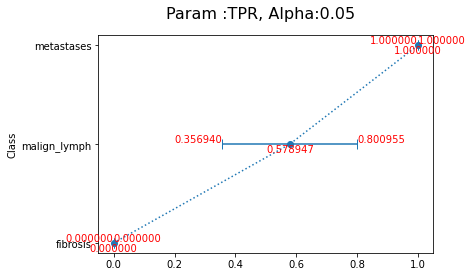

In [37]:
plot_ci(cm1,param="TPR",method="normal-approx")

95%CI :
fibrosis : (0.0, 0.0)
malign_lymph : (-0.050265423276822124, 0.16137653438793328)
metastases : (0.21691132368626137, 0.6402315334565958)


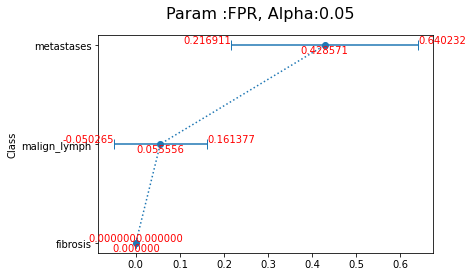

In [38]:
plot_ci(cm1,param="FPR",method="normal-approx")